Test slab_model.py
==================

Jinbo Wang

Jinbo.Wang@jpl.nasa.gov

Revision history

1. last update: 12/31/2021 copied from full_wacm-scenario.ipynb
1. pick up on 4/25/2023, use the new (old now) odysea_class to generate the time stamps. 

# WaCM was generated from the original

Highpass filtering and detides will be performed on the simulated WaCM data.

In [20]:
%load_ext autoreload
%autoreload 2

In [21]:
import glob 
import os

import sys
sys.path.append('../src')
sys.path.append('../')

import slab_model
import pylab as plt
import numpy as np
import xarray as xr
from scipy.io import loadmat
import pandas as pd
import pickle
import odysea_class
import utils
from scipy import signal

xrod=xr.open_dataset

import coas

In [46]:
coas_model = coas.COAS(days=10)

display(coas_model.U)
display(coas_model.TX)


<xarray.Dataset>
Dimensions:  (time: 479, lat: 1126, lon: 2250)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-19T22:00:00 ... 2020-02-08T20:00:00
  * lat      (lat) float64 -89.94 -89.78 -89.62 -89.46 ... 89.58 89.74 89.9 90.0
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.5 ... 179.6 179.7 179.9
Data variables:
    U        (time, lat, lon) float64 dask.array<chunksize=(1, 1126, 2250), meta=np.ndarray>

<xarray.Dataset>
Dimensions:  (time: 479, lat: 1126, lon: 2250)
Coordinates:
  * time     (time) datetime64[ns] 2020-01-19T22:00:00 ... 2020-02-08T20:00:00
  * lat      (lat) float64 -89.94 -89.78 -89.62 -89.46 ... 89.58 89.74 89.9 90.0
  * lon      (lon) float64 -179.9 -179.8 -179.6 -179.5 ... 179.6 179.7 179.9
Data variables:
    TX       (time, lat, lon) float64 dask.array<chunksize=(1, 1126, 2250), meta=np.ndarray>

<xarray.DataArray 'time' (time: 336)>
array(['2020-01-19T22:00:00.000000000', '2020-01-19T23:00:00.000000000',
       '2020-01-20T00:00:00.000000000', ..., '2020-02-02T19:00:00.000000000',
       '2020-02-02T20:00:00.000000000', '2020-02-02T21:00:00.000000000'],
      dtype='datetime64[ns]')
Coordinates:
  * time     (time) datetime64[ns] 2020-01-19T22:00:00 ... 2020-02-02T21:00:00


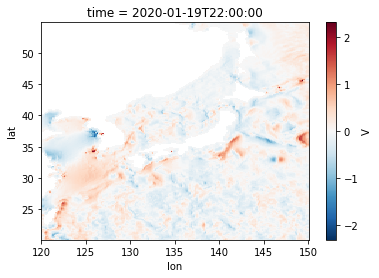

In [3]:
aa=coas_model.V['V'][0,...].sel(lon=slice(120,150),lat=slice(20,55)).plot()
print(coas_model.V.time[:24*14])

In [4]:
lon0,lat0=-145,25
ddeg = 0.2
model_time=coas_model.U['U']
u=coas_model.U['U'].sel(lon=slice(lon0-ddeg,lon0+ddeg),
                        lat=slice(lat0-ddeg,lat0+ddeg))
u

<xarray.DataArray 'U' (time: 479, lat: 2, lon: 2)>
dask.array<getitem, shape=(479, 2, 2), dtype=float64, chunksize=(1, 2, 2), chunktype=numpy.ndarray>
Coordinates:
  * time     (time) datetime64[ns] 2020-01-19T22:00:00 ... 2020-02-08T20:00:00
  * lat      (lat) float64 24.94 25.1
  * lon      (lon) float64 -145.1 -144.9

## Check the region average vs one-point time series.

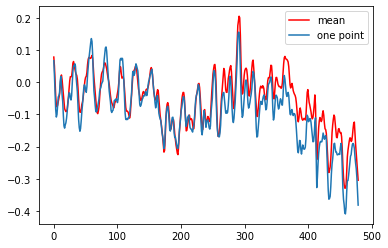

In [5]:
uu=u.data.reshape(u.shape[0],-1).mean(axis=-1)
plt.plot(uu,'r',label='mean')
plt.plot(u.data[:,0,0],label='one point')
plt.legend()

## Get u,v,tx,ty for a subtropical region south of KE

In [80]:
lon0,lat0=-145,40
ddeg = 0.2
model_time=coas_model.U['U'].time

vns=['U','V','TX','TY']
dd = coas_model
data0 = [dd.U, dd.V, dd.TX, dd.TY]
data1 = []
for vn, din in zip(vns,data0):
    dtm=din[vn].sel(
        lon=slice(lon0-ddeg,lon0+ddeg),
        lat=slice(lat0-ddeg,lat0+ddeg))
    dtm=dtm.data.reshape(model_time.size,-1).mean(axis=-1).compute()
    dtm=xr.DataArray(data=dtm,dims=('time'),coords={'time':model_time})
    if vn in ['U','V']:
        #dtm=slab_model.NIO_bandpass(dtm,lat0,[0.96,1.04])
        dtm_low,dtm_high=slab_model.filter_seperation(dtm,1/5)
    data1.append(dtm-dtm_low)


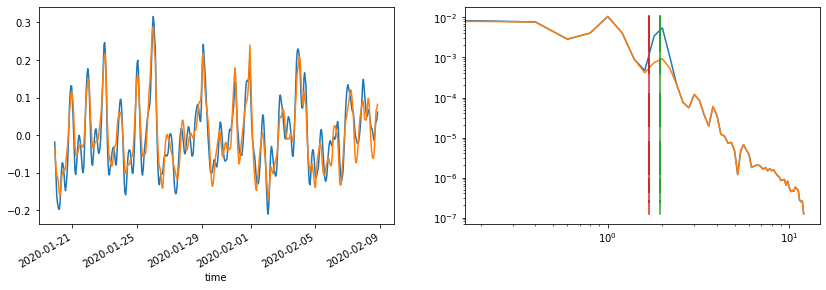

In [72]:
fig,ax=plt.subplots(1,2,figsize=(14,4))

data1[0].plot(ax=ax[0])
a,b=signal.welch(data1[0].data,nfft=5*24,nperseg=5*24,noverlap=60,detrend='linear',fs=24)
ax[1].loglog(a,b)

dtm = slab_model.remove_tides(data1[0:2],lat0,['M2','M4'])
data1[0:2]=dtm[:2]
dtm[0].plot(ax=ax[0])

a,b=signal.welch(dtm[0].data,nfft=5*24,nperseg=5*24,noverlap=60,detrend='linear',fs=24)
ax[1].loglog(a,b)
ax[1].loglog(np.ones_like(a)/12.4*24,b)
ax[1].loglog(np.ones_like(a)/14.25*24,b)


### Plot the time series to double check the validity

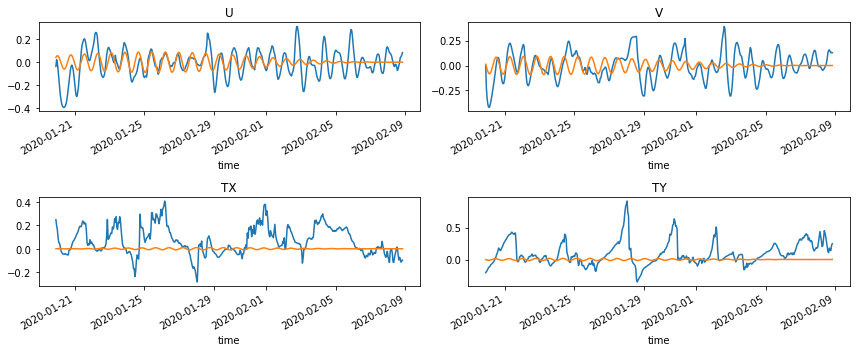

In [81]:
fig,axs=plt.subplots(2,2,figsize=(12,5))
for ax,dd, vn in zip(axs.flatten(),data1,vns):
    dd.plot(ax=ax)
    ax.plot(dd.time,slab_model.NIO_bandpass(dd,lat0,[0.96,1.04]))
    ax.set_title(vn)
plt.tight_layout()

## Optimize and find the NIO solution

### Find the satellite passing time

In [82]:
sat_time=odysea_class.wacmLatLon().getSamplingTimes([lat0],[lon0],model_time[0].data,model_time[-1].data)[0]
print(sat_time)

['2020-01-19T23:23:12.000000000' '2020-01-20T23:44:32.000000000'
 '2020-01-21T13:08:48.000000000' '2020-01-22T00:03:44.000000000'
 '2020-01-23T00:25:04.000000000' '2020-01-23T12:13:20.000000000'
 '2020-01-23T23:23:12.000000000' '2020-01-24T23:44:32.000000000'
 '2020-01-25T13:08:48.000000000' '2020-01-26T00:03:44.000000000'
 '2020-01-27T00:25:04.000000000' '2020-01-27T12:13:20.000000000'
 '2020-01-27T23:23:12.000000000' '2020-01-28T23:44:32.000000000'
 '2020-01-29T13:08:48.000000000' '2020-01-30T00:03:44.000000000'
 '2020-01-31T00:25:04.000000000' '2020-01-31T12:13:20.000000000'
 '2020-01-31T23:23:12.000000000' '2020-02-01T23:44:32.000000000'
 '2020-02-02T13:08:48.000000000' '2020-02-03T00:03:44.000000000'
 '2020-02-04T00:25:04.000000000' '2020-02-04T12:13:20.000000000'
 '2020-02-04T23:23:12.000000000' '2020-02-05T23:44:32.000000000'
 '2020-02-06T13:08:48.000000000' '2020-02-07T00:03:44.000000000'
 '2020-02-08T00:25:04.000000000' '2020-02-08T12:13:20.000000000']


### Generate (interpolate) model data onto the satellite passing time

In [83]:
data2 = []
for da in data1:
    data2.append(da.interp(time=sat_time))

data2[0]

<xarray.DataArray (time: 30)>
array([ 0.00974165, -0.17526647,  0.20352849,  0.09948695,  0.10518945,
       -0.04365104,  0.11842071, -0.130964  ,  0.01530307,  0.03294448,
        0.02725846,  0.01873382,  0.00695391, -0.20130196, -0.00806288,
        0.05773952,  0.11322797,  0.12438208, -0.06466562,  0.06209622,
       -0.07518864, -0.03189147, -0.16148117,  0.01074683,  0.09871757,
        0.16754739,  0.0405423 , -0.04173571,  0.11559681, -0.04834787])
Coordinates:
  * time     (time) datetime64[ns] 2020-01-19T23:23:12 ... 2020-02-08T12:13:20

### Check the original and odysea time series

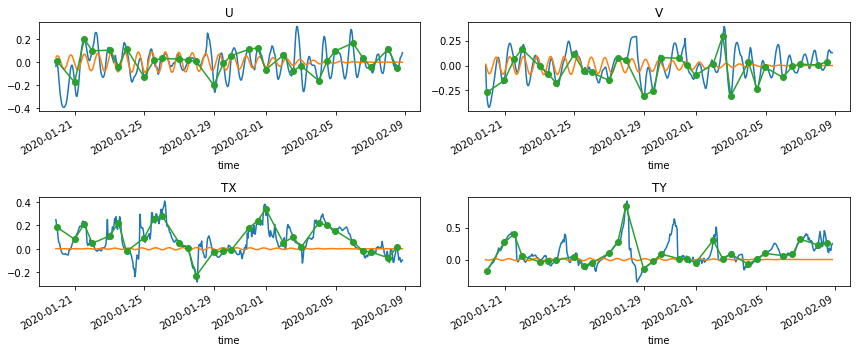

In [84]:
fig,axs=plt.subplots(2,2,figsize=(12,5))
for ax,dd1,dd2,vn in zip(axs.flatten(),data1,data2,vns):
    dd1.plot(ax=ax)
    ax.plot(dd1.time,slab_model.NIO_bandpass(dd1,lat0))
    dd2.plot(ax=ax,marker='o')
    ax.set_title(vn)
plt.tight_layout()

### Optimize

In [92]:
slab_result=slab_model.optimize_slab_noshear_withtide(data2[0].time.data,
                                          data2[0].data,data2[1].data,
                                          data2[2].time.data,
                                          data2[2].data,
                                          data2[3].data,
                                          utils.lat2f(lat0),
                                          has_tides=False,
                                          t_out=[],
                                          T_tide=[],
                                          is_windstress=False,c_clim=40,c_max=100,c_min=30,use_weight=True)
slab_result

<xarray.Dataset>
Dimensions:          (time: 469)
Coordinates:
  * time             (time) datetime64[ns] 2020-01-19T23:23:12 ... 2020-02-08...
Data variables:
    nio_u_predicted  (time) float64 0.1183 0.1041 0.07911 ... 0.02337 0.01782
    nio_v_predicted  (time) float64 -0.06502 -0.1001 ... -0.05579 -0.06005
    H                float64 100.0
    c                float64 1e-06
    cost             float64 0.2149
    success          bool True

### plot the predicted velocity

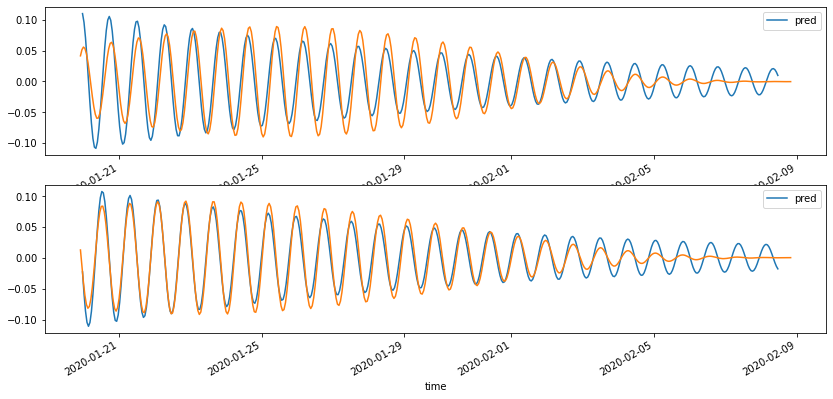

In [93]:
fig,ax=plt.subplots(2,1,figsize=(14,6))

u=slab_result.nio_u_predicted;u-=u.mean()
u.plot(ax=ax[0],label='pred')
u=slab_model.NIO_bandpass(data1[0],lat0,[0.96,1.04]);u-=u.mean()
u.plot(ax=ax[0])
ax[0].legend()

u=slab_result.nio_v_predicted;u-=u.mean()
u.plot(ax=ax[1],label='pred')
u=slab_model.NIO_bandpass(data1[1],lat0,[0.96,1.04]);u-=u.mean()
u.plot(ax=ax[1])
ax[1].legend()
